# Contrast Information in IDYoMS

This note book contains code which computes the forward contrast information profiles using a modified version of Idyoms. The main difference in this modified version of Idyoms is that n-grams now consist of three parts: past, present and future. The past and the future are each sequences of symbols and the present is a single symbol. These are essentially "nm-grams" where n is the length of the past and m is the length of the future. For now, m (the length of the future) is limited to 1. Past, present and future can each come from a different viewpoint. Tallies of these nm-grams are constructed as needed and used to compute PPM distributions, which in turn are used to compute forward contrast information. There is not one single sensible way to apply the PPM algorithm to compute the required distributions; there are different possible ways that smoothing could be applied. What we've done here represents the logical first attempt.

In [1]:
using Chakra
include("./Idyoms.jl")
using Main.Idyoms

### 1. Load seqeunce data

In [2]:
using Melch
Melch.__INIT__("/Users/nick/Work/MelchData")
nova = fnd(Melch.id(0),Melch)
melodies = pts(nova)
sequences = [sequence(pts(mel,Melch),Melch) for mel in melodies];

### 2. Define viewpoints

In [3]:
# DEFINE VIEWPOINTS

CPITCH = vp(Melch.CPITCH)
DUR = vp(Melch.DUR)

# SET X,Y,Z VIEWPOINTS

X = CPITCH
Y = CPITCH
Z = CPITCH

V = link(CPITCH,DUR)

Chakra.LinkedViewpoint{Tuple{Int64, Int64}}(Viewpoint[Chakra.AtomicViewpoint{Int64}(Melch.Attribute{:CPITCH, Int64}(), Type[Int64]), Chakra.AtomicViewpoint{Int64}(Melch.Attribute{:DUR, Int64}(), Type[Int64])], DataType[Int64, Int64])

### 3. Construct views of seqeunces using viewpoints

In [4]:
views = [View(seq,V,V,V) for seq in sequences];

### 4. Extract list of ngrams from views

In [5]:
n,m = Bounded(5),Bounded(1);
@time gs = NMgs(views,n,m);

  0.246701 seconds (1.16 M allocations: 97.305 MiB, 2.21% gc time, 99.07% compilation time)


### 5. Construct tallies from ngrams

In [6]:
txyZ = Idyoms.tally_xyZ(gs);
txzY = Idyoms.tally_xzY(gs);
txZ = Idyoms.tally_xZ(gs);
tyZ = Idyoms.tally_yZ(gs);
txY = Idyoms.tally_xY(gs);
#tzY = Idyoms.tally_zY(gs);

### 6. Construct alphabets from ngrams

In [7]:
dX = Set([g[1] for g in gs]);
dY = Set([g[2] for g in gs]);
dZ = Set([g[3] for g in gs]);

### 7. Compute PPM distributions

In [8]:
# PARAMTERS

b = Interpolated()
e = C()
u = true

# DISTRIBUTIONS

dist(x,t,s,a,b,e,u) = Idyoms.estimate_dist(x,t,s,a,b,e,u)[1];

pZxy(x::Seq{X},y::Y) where {X,Y} = dist((x=>y),txyZ,dZ,dZ,b,e,u);
pZy(y::Y) where Y = @views dist([y][1:end],tyZ,dZ,dZ,b,e,u);
pZx(x::Seq{X}) where X = dist(x,txZ,dZ,dZ,b,e,u);
#pZx2(x::Seq{X}) where X = Distribution{Int}([z=>sum([pYx(x)(y)*pZxy(x,y)(z) for y in dY]) for z in dZ]...);
pYx(x::Seq{X}) where X = dist(x,txY,dY,dY,b,e,u);
pYxz(x::Seq{X},z::Z) where {X,Z} = dist((x=>z),txzY,dY,dY,b,e,u);

### 8. Compute forward contrast information

In [9]:
function FCI(x::Seq{X},y::Y,z::Seq{Z}) where {X,Y,Z}

    pzxy = pZxy(x,y)
    pzx = pZx(x)
    pzy = pZy(y)
    pyxz = pYxz(x,z)
    pyx = pYx(x)

    fpc = sum([pzxy(z)*log(2,pzxy(z)/pzx(z)) for z in dZ])
    fcc = sum([pzxy(z)*log(2,pzxy(z)/pzy(z)) for z in dZ])
    fri = sum([pyxz(y)*log(2,pyxz(y)/pyx(y)) for y in dY])

    return fpc, fcc, fri
    
end

function FCI(v::View{X,Y,Z}) where {X,Y,Z}

    fci = [FCI(nmg(v,i)...) for i in 1:length(v)]
    fpc = [t[1] for t in fci];
    fcc = [t[2] for t in fci];
    frc = [t[3] for t in fci];

    return fpc, fcc, frc

end

@time fci = [FCI(view) for view in views];

116.168550 seconds (2.49 G allocations: 379.992 GiB, 13.40% gc time, 0.57% compilation time)


### 9. Plot

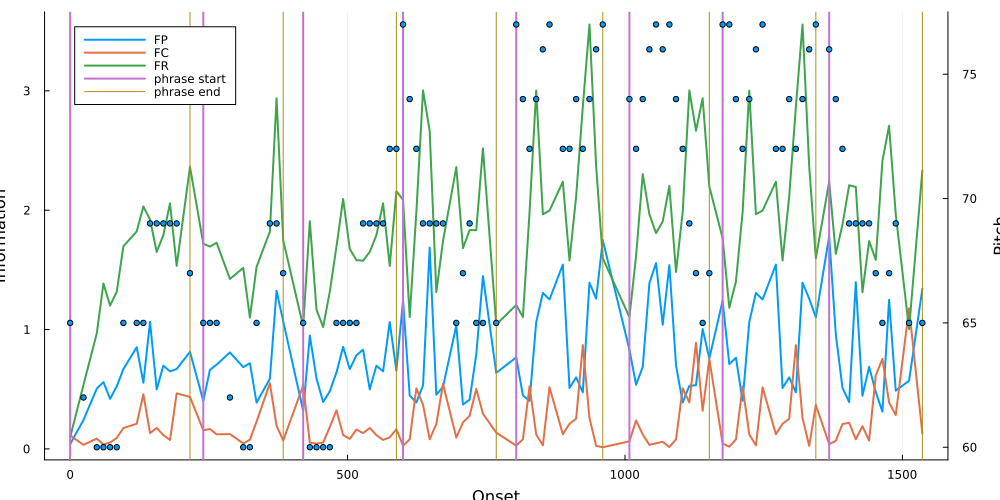

In [10]:
m = 1
seq = sequences[m];

fpc = fci[m][1]
fcc = fci[m][2]
frc = fci[m][3]

using Plots
onsets = [e.ONSET for e in seq];
pitches = [e.CPITCH for e in seq];
phrase_start = [e.ONSET for e in seq if e.PHRASE == 1];
phrase_end = [e.ONSET for e in seq if e.PHRASE == -1];

plot(onsets,fpc, label = "FP",lw=2,ylabel="Information",xlabel="Onset",legend=:topleft)
plot!(onsets,fcc, label = "FC",lw=2)
plot!(onsets,frc, label = "FR",lw=2)

vline!(phrase_start, lw = 2,label="phrase start")
vline!(phrase_end,lw=1,label="phrase end")
scatter!(twinx(),onsets,pitches,label="pitch",markersize=3,ylabel="Pitch",legend=false)

plot!(plot!(size=(1000,500)))